In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [2]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

In [3]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [6]:
#Lines from the file of Clean lines
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visible range\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
614,10425.8870
615,10426.6020
616,10535.1220
617,10580.0390


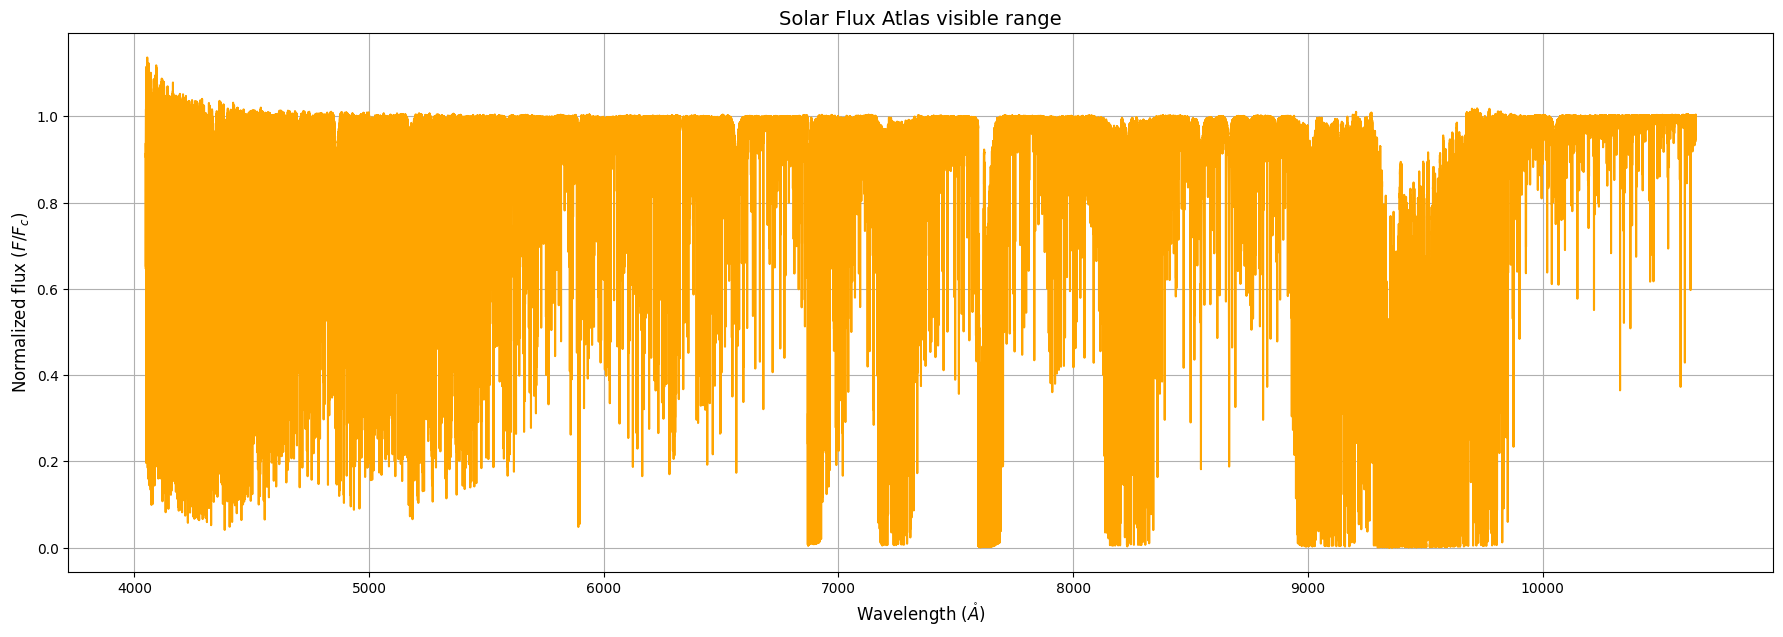

In [7]:
#Plot of raw data
#Plot of raw data
fig1, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(raw_data['Wave A'],raw_data['nFlux'], color='orange')
ax.set_title('Solar Flux Atlas visible range',fontsize=14)
ax.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=12)
ax.set_ylabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.grid()

# fig1.savefig('Spectrum_VIS.png')

### Find the minimums and the closer line of the Fe I line


In [8]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)

closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])


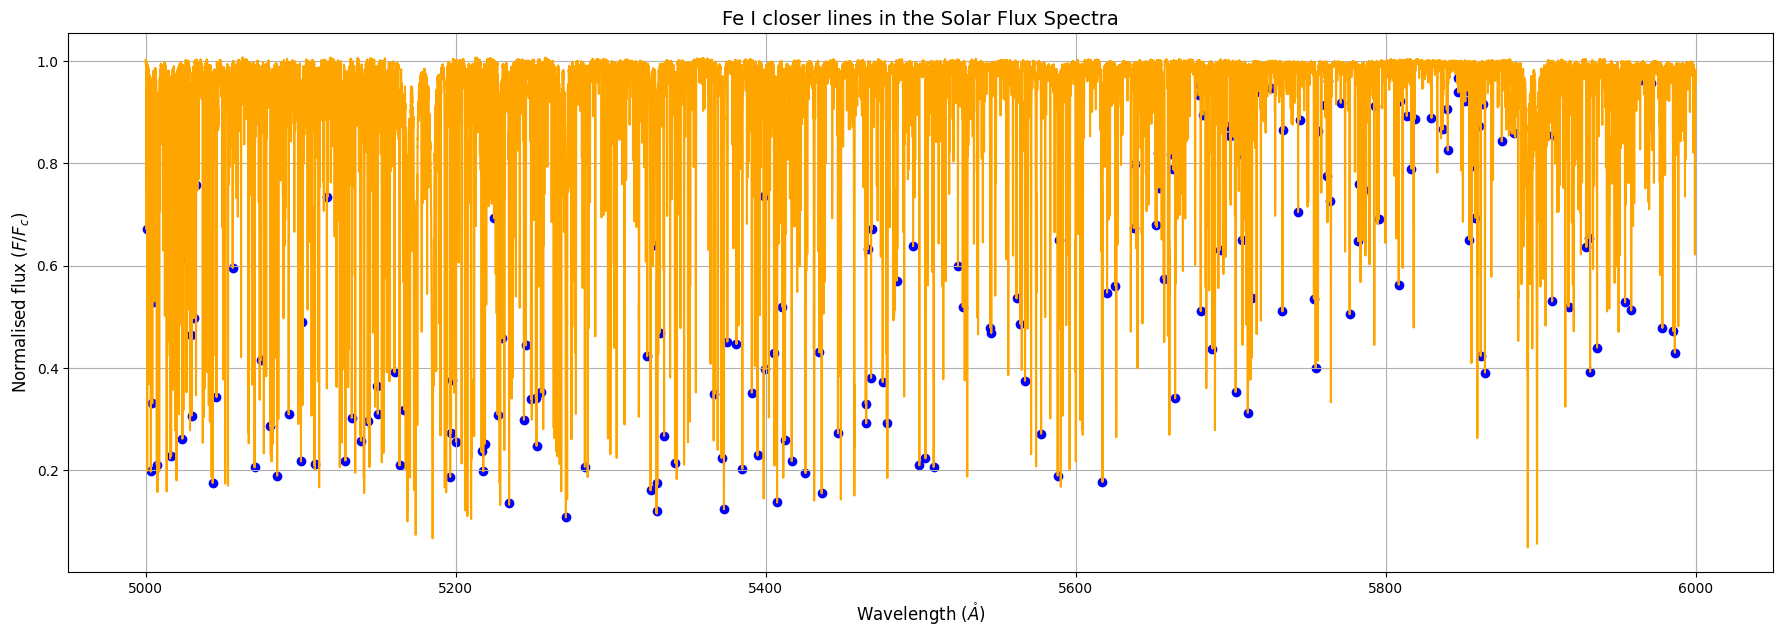

In [9]:
#Plot the identified lines
fig2, ax = plt.subplots(1,1,figsize=(22,7))

#Just for the plot, separte in the range 5000-6000 A
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000,6000,inclusive='right')]
closer_lines_5000_6000 = closer_lines[closer_lines['Fe line'].between(5000,6000,inclusive='right')]

ax.plot(data_5000_6000['Wave A'],data_5000_6000['nFlux'], color='orange')
ax.scatter(closer_lines_5000_6000['min_wave'],closer_lines_5000_6000['min_flux'], color='blue')

ax.set_title('Fe I closer lines in the Solar Flux Spectra',fontsize=14)
ax.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=12)
ax.set_ylabel(r'Normalised flux $(F/F_{c})$',fontsize=12)
ax.grid()

In [10]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05)

### Derivates and fit

In [11]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed
            d2 = poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2) #Re-scalated the coefficients
            d3 = Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","2nd Derivate","3rd Derivate","Blueshift"]

    return Values

Values = Fit_derivates(local_points,closer_lines['Fe line'])

Values

,Emitted wavelength,Observed wavelength,Flux,Velocity,2nd Derivate,3rd Derivate,Blueshift
0,4060.8601,4060.8637,0.319656,-367,516.240027,156.775163,265.769522
1,4068.4198,4068.4255,0.209893,-213,305.398066,-407.860166,420.019834
2,4080.9899,4080.9941,0.214181,-324,412.428492,-295.360703,308.535026
3,4086.1573,4086.1634,0.220922,-185,317.419952,-379.360689,447.543709
4,4088.2476,4088.2510,0.288719,-384,466.796632,52.068406,249.323049
...,...,...,...,...,...,...,...
614,10425.8870,10425.8953,0.865886,-394,27.385089,-423.048679,238.663377
615,10426.6020,10426.6082,0.828438,-455,34.097704,123.851195,178.266442
616,10535.1220,10535.1327,0.693736,-329,48.369722,148.915844,304.484305
617,10580.0390,10580.0488,0.901829,-355,15.526598,-4083.937282,277.689533


In [12]:
##Convert to excel file
# Values.to_excel('valores_VIS.xlsx', index=False)

## Graphics 

As we have an absorption spectrum, the line depth is measurement one minus the flux value.

### Velocity vs Normalized Flux

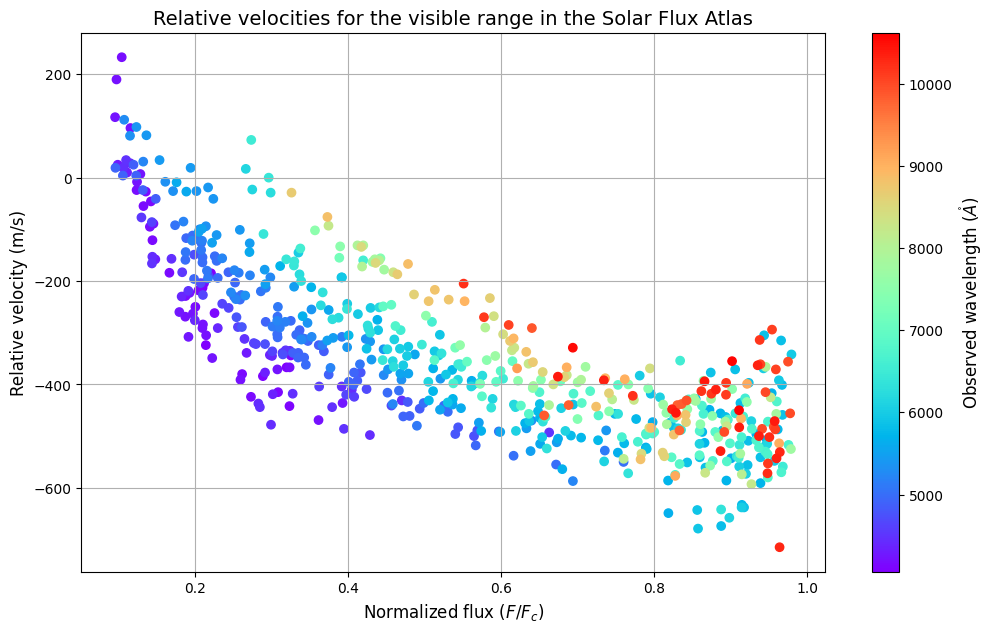

In [13]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Velocity'],c=Values["Observed wavelength"],cmap='rainbow',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Relative velocities for the visible range in the Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$', fontsize=12)
ax.set_ylabel('Relative velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('Velocity_VIS.png')

### Second Derivate vs Normalized Flux

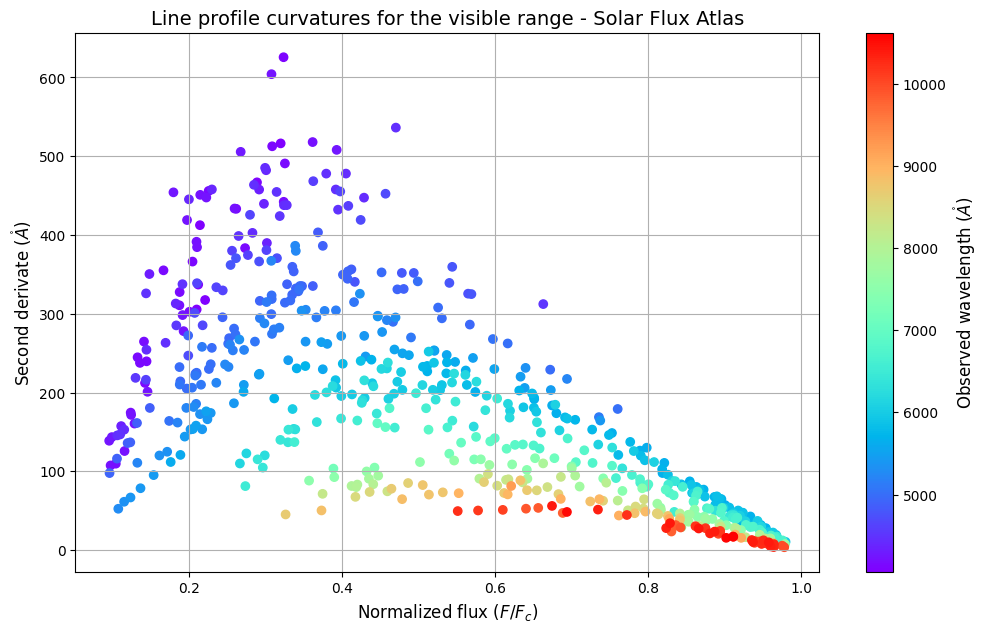

In [14]:
fig4, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['2nd Derivate'],c=Values["Observed wavelength"],cmap='rainbow',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile curvatures for the visible range - Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Second derivate $(\mathring{A})$',fontsize=12)
ax.grid()

# fig4.savefig('Curvature_VIS.png')

### Third Derivate Expresion vs Normalized Flux

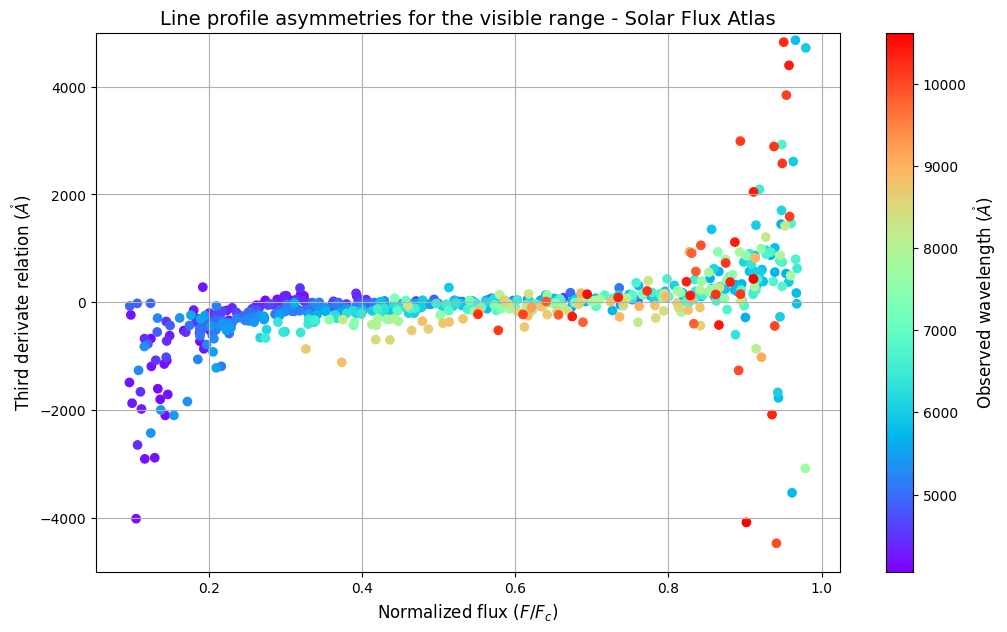

In [15]:
fig5, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['3rd Derivate'],c=Values["Observed wavelength"],cmap='rainbow',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile asymmetries for the visible range - Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Third derivate relation $(\mathring{A})$',fontsize=12)
ax.set_ylim(-5000,5000)
ax.grid()

# fig5.savefig('CBisector_VIS.png')

### Convective Blueshift vs Line Depth

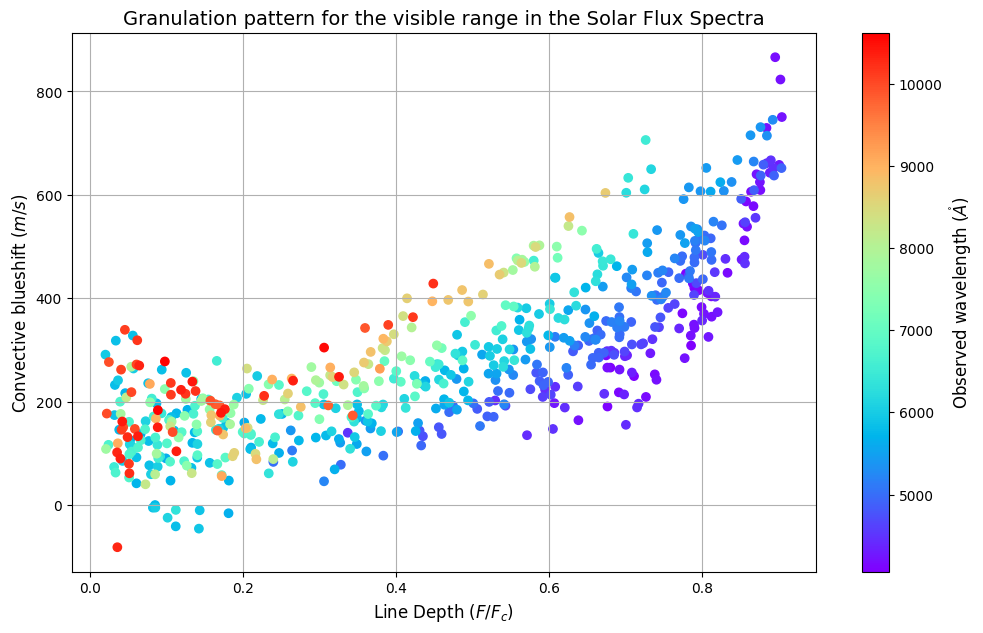

In [16]:
fig6, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(1-Values['Flux'],Values['Blueshift'],c=Values["Observed wavelength"],cmap='rainbow',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Granulation pattern for the visible range in the Solar Flux Spectra',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Convective blueshift $(m/s)$',fontsize=12)
ax.grid()

# fig6.savefig('ConvectiveBlueshift_VIS.png')

### Velocity vs normalized depth

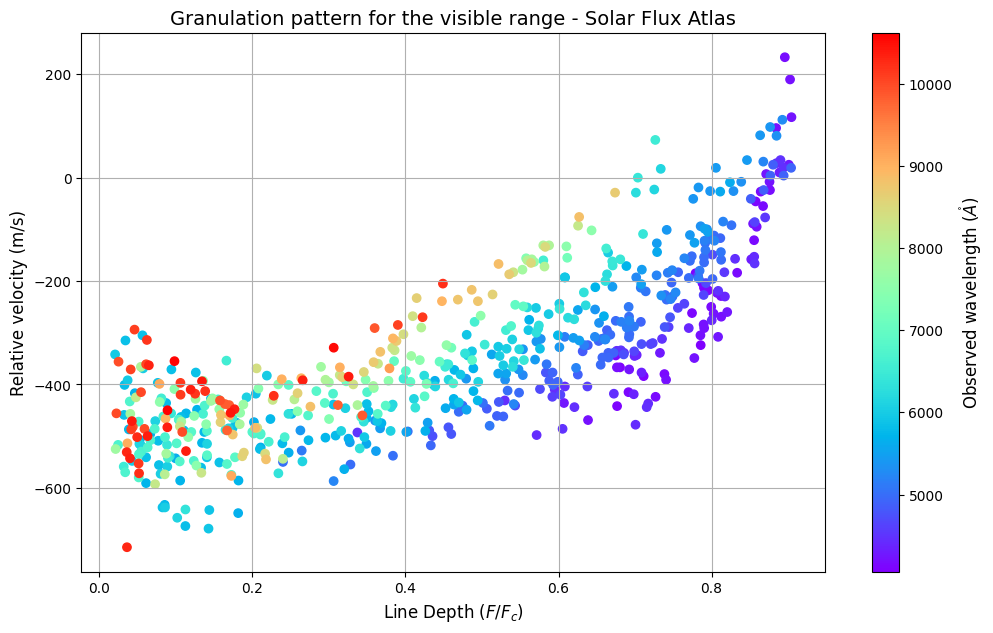

In [17]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(1-Values['Flux'],Values['Velocity'],c=Values["Observed wavelength"],cmap='rainbow',lw=1)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Granulation pattern for the visible range - Solar Flux Atlas',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{c})$', fontsize=12)
ax.set_ylabel('Relative velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('GranulationPattern_VIS.png')